In [1]:
its_jupyter_notebook = True
# %load_ext autoreload
# %autoreload 2

import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from tqdm.notebook import tqdm
from pathlib import Path
import argparse
import math
from scipy import stats
import copy
import re
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable

sys.path.insert(0, '..')

from util.evaluation import ModelResultsManager, calculate_correlations, balancing_only_for_one_task, obtain_all_model_auc, remove_outliers, map_thermodynamic_columns, obtain_df_auc, replace_outliers_with_nan_and_make_positive, obtain_sr_nosr, map_dataset_to_hp
from util.plot_utils import npv_precision, plot_sr_distributions, calc_metric, plot_tnr_based_on_distance_for_our_model, collect_results_based_on_topbottom_for_all_models, plot_results_based_on_topbottom_for_all_models, plot_results_how_many_repeats_in_pred_pos_for_all_models, plot_metric_confidence_for_all_models, plot_tnr_based_on_distance_for_all_models, plot_confidence_based_on_distance_for_all_models, plot_tnr_for_all_models, quantile_bins, plot_features_vs_risearch2_confidence, plot_heatmap, plot_tnr_recall_for_all_models, plot_correlation_nreads_prob_intsize
from util.model_names_map import map_model_names
from run_compare_models import load_results_new
#from run_compare_models import load_results_new

from config import *
from models.nt_classifier import build as build_model 
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!
    
external_dataset_dir = os.path.join(dataset_files_dir, 'external_dataset', '200_test_tables')

<class 'transformers.tokenization_dna.DNATokenizer'>


In [125]:
checkpoint_dir_paths = []

chkpt_folder = os.path.join(ROOT_DIR, 'checkpoints')

models_to_check = os.listdir(chkpt_folder)
for model_name in models_to_check:
    model_folder = os.path.join(chkpt_folder, model_name)
    test_paris = os.path.join(chkpt_folder, model_name, 'test_results200.csv')
    ricseq = os.path.join(chkpt_folder, model_name, 'ricseq_results200.csv')
    splash = os.path.join(chkpt_folder, model_name, 'splash_results200.csv')
    mario = os.path.join(chkpt_folder, model_name, 'mario_results200.csv')

    if os.path.exists(test_paris) & os.path.exists(ricseq) & os.path.exists(splash) & os.path.exists(mario):
        checkpoint_dir_paths.append(model_folder)

In [126]:
for i in range(1, 2):
    df, name_map = load_results_new(checkpoint_dir_paths[:i], chkpt_folder)

In [127]:
mean_aucHQ = df.filter(['auc_interactors_parisHQ', 'auc_patches_parisHQ', 'auc_interactors_ricseqHQ', 'auc_patches_ricseqHQ'], axis = 1).mean(axis = 1)

mean_tnr = df.filter(['tnr_psoralen', 'tnr_ricseq', 'tnr_paris_mouse', 'tnr_mario'], axis = 1).mean(axis = 1)
mean_prec = df.filter(['precision_psoralen', 'precision_ricseq', 'precision_paris_mouse', 'precision_mario'], axis = 1).mean(axis = 1)
mean_recall = df.filter(['recall_psoralen', 'recall_ricseq', 'recall_paris_mouse', 'recall_mario'], axis = 1).mean(axis = 1)

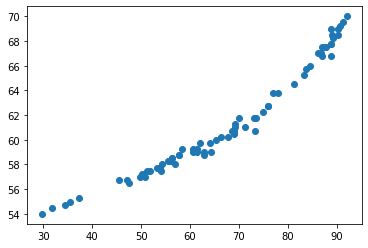

In [128]:
plt.scatter(mean_tnr, mean_prec)

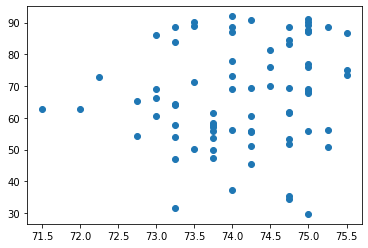

In [129]:
plt.scatter(mean_aucHQ, mean_tnr)

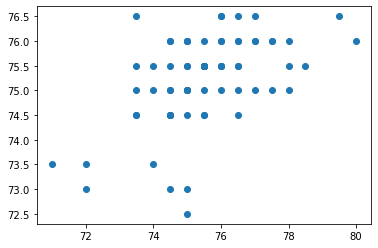

In [130]:
mean_aucvalHQ = df.filter(['auc_interactors_val_HQ', 'auc_patches_val_HQ'], axis = 1).mean(axis = 1)
mean_auctestHQ = df.filter(['auc_interactors_parisHQ', 'auc_patches_parisHQ'], axis = 1).mean(axis = 1)
plt.scatter(mean_aucvalHQ, mean_auctestHQ)

In [131]:
MIN_TNR = 70
MIN_AUC = 75

best_models = df[
    (mean_tnr >= MIN_TNR) &
    (mean_aucHQ >= MIN_AUC)
]

In [132]:
best_models.filter([
    'auc_interactors_parisHQ', 'auc_patches_parisHQ', 
    'auc_interactors_paris_mouse_HQ', 'auc_patches_paris_mouse_HQ',
    'auc_interactors_ricseqHQ', 'auc_patches_ricseqHQ'
], axis = 1)

,auc_interactors_parisHQ,auc_patches_parisHQ,auc_interactors_paris_mouse_HQ,auc_patches_paris_mouse_HQ,auc_interactors_ricseqHQ,auc_patches_ricseqHQ
5,73.0,79.0,60.0,75.0,71.0,77.0
6,73.0,79.0,62.0,77.0,72.0,78.0
37,72.0,79.0,61.0,77.0,71.0,78.0
38,72.0,79.0,59.0,75.0,71.0,78.0
40,73.0,79.0,60.0,76.0,70.0,78.0
43,72.0,79.0,62.0,78.0,71.0,78.0
46,72.0,79.0,61.0,76.0,71.0,78.0
49,73.0,79.0,59.0,75.0,71.0,78.0
52,72.0,79.0,61.0,75.0,71.0,78.0
56,73.0,80.0,59.0,75.0,71.0,78.0


In [133]:
for _, row in best_models.iterrows():
    print(_, name_map[row.model])

5 /data01/giorgio/RNARNA-NT/checkpoints/arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0054
6 /data01/giorgio/RNARNA-NT/checkpoints/arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0057
37 /data01/giorgio/RNARNA-NT/checkpoints/arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0056
38 /data01/giorgio/RNARNA-NT/checkpoints/arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0063
40 /data01/giorgio/RNARNA-NT/checkpoints/arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0030
43 /data01/giorgio/RNARNA-NT/checkpoints/arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0043
46 /data01/giorgio/RNARNA-NT/checkpoints/arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0052
49 /data01/giorgio/RNARNA-NT/checkpoints/arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0066
52 /data01/giorgio/RNARNA-NT/checkpoints/arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight

# Best model in the same training

In [134]:
def extract_last_digits(text):
    # Search for the last number pattern at the end of the string
    match = re.search(r'(\d+)(?!.*\d)', text)
    return match.group(1) if match else None

In [135]:
folder_name = 'arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest' #'arch2_PARIStrained_PARISval'

folders = []

checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', folder_name)

# List of files
files = os.listdir(checkpoint_dir)

# Dictionary to store filenames and their values
desired_files = {}

# Regular expression pattern to extract numbers or 'BEST'
pattern = re.compile(r'checkpoint(\d+).pth|checkpointBEST.pth')

for file in files:
    match = pattern.match(file)
    if match:
        value = match.group(1) if match.group(1) else 'BEST'
        desired_files[file] = value

for i in desired_files.keys():
    ckpt_folder = checkpoint_dir+desired_files[i]
    folders.append(os.path.basename(ckpt_folder))

In [136]:
names_df = pd.DataFrame.from_dict(name_map, 'index').reset_index().rename({0:'model_path_folder', 'index':'model_name'}, axis = 1)
names_df

,model_name,model_path_folder
0,model0,/data01/giorgio/RNARNA-NT/checkpoints/arch2_PA...
1,model1,/data01/giorgio/RNARNA-NT/checkpoints/arch2_PA...
2,model2,/data01/giorgio/RNARNA-NT/checkpoints/arch2_PA...
3,model3,/data01/giorgio/RNARNA-NT/checkpoints/arch2_PA...
4,model4,/data01/giorgio/RNARNA-NT/checkpoints/arch2_PA...
...,...,...
71,model71,/data01/giorgio/RNARNA-NT/checkpoints/arch2_PA...
72,model72,/data01/giorgio/RNARNA-NT/checkpoints/arch2_PA...
73,model73,/data01/giorgio/RNARNA-NT/checkpoints/arch2_PA...
74,model74,/data01/giorgio/RNARNA-NT/checkpoints/arch2_PA...


In [137]:
names_df = pd.DataFrame.from_dict(name_map, 'index').reset_index().rename({0:'model_path_folder', 'index':'model_name'}, axis = 1)

rows = []
for folder in folders:
    model_path_folder=os.path.join(chkpt_folder, folder)
    names_df_row = names_df[names_df.model_path_folder == model_path_folder]
    if names_df_row.shape[0]>0:
        names_df_row = names_df_row.iloc[0]
        rows.append({
            'original_model_name':folder,
            'model':names_df_row.model_name,
            'epoch':int(extract_last_digits(folder)),
            'model_path_folder':model_path_folder,
            })
    
training = pd.DataFrame(rows).sort_values('epoch', ascending = True).reset_index(drop = True)

In [138]:
df_plot = training.merge(df[['model','auc_interactors_val', 'auc_patches_val', 'auc_interactors_paris', 'auc_patches_paris']], on ='model')

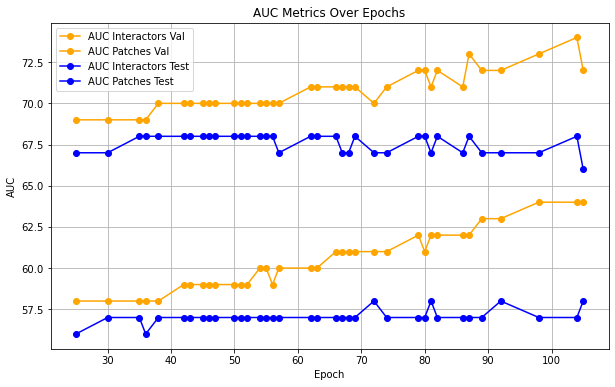

In [139]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_plot['epoch'], df_plot['auc_interactors_val'], color = 'orange', label='AUC Interactors Val', marker='o')
plt.plot(df_plot['epoch'], df_plot['auc_patches_val'], color = 'orange', label='AUC Patches Val', marker='o')
plt.plot(df_plot['epoch'], df_plot['auc_interactors_paris'], color = 'blue', label='AUC Interactors Test', marker='o')
plt.plot(df_plot['epoch'], df_plot['auc_patches_paris'], color = 'blue', label='AUC Patches Test', marker='o')

# Labels and title
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [140]:
df_plot = training.merge(df[['model','auc_interactors_val_HQ', 'auc_patches_val_HQ', 'auc_interactors_parisHQ', 'auc_patches_parisHQ']], on ='model')

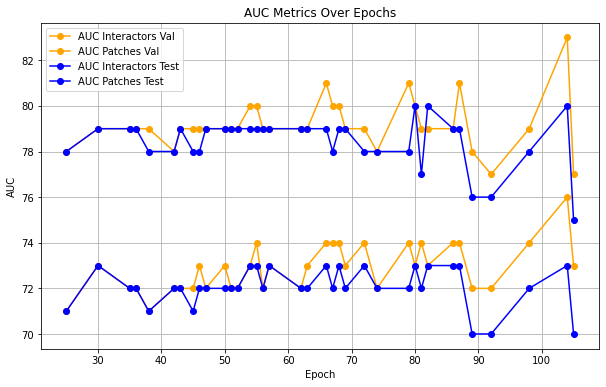

In [141]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_plot['epoch'], df_plot['auc_interactors_val_HQ'], color = 'orange', label='AUC Interactors Val', marker='o')
plt.plot(df_plot['epoch'], df_plot['auc_patches_val_HQ'], color = 'orange', label='AUC Patches Val', marker='o')
plt.plot(df_plot['epoch'], df_plot['auc_interactors_parisHQ'], color = 'blue', label='AUC Interactors Test', marker='o')
plt.plot(df_plot['epoch'], df_plot['auc_patches_parisHQ'], color = 'blue', label='AUC Patches Test', marker='o')

# Labels and title
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.show()